# Pilot Topic Survey
## Imports and Constants

In [1]:
# Analytical Tools
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from scipy import stats

# Utilities
import math
import json
import pprint
import literals.social_follow_up as literals
from tools import datajson, grouping, utilities

# Make printing much more convenient
log = pprint.pprint

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext pycodestyle_magic

/Users/hermish/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [4]:
LOCATION = '../private/output/social-follow-up-entries.json'
Q_TEXT = literals.questions_and_answers['questions']
QUESTIONS = {ques: 'q' + str(num) for num, ques in enumerate(Q_TEXT)}

J_TEXT = literals.judgements
JUDGEMENTS = {judge: 'j' + str(num) for num, judge in enumerate(J_TEXT)}

## Reading in Data
Open the file containing all the data and reads it in line by line.

In [13]:
with open(LOCATION) as file:
    master_responses = [json.loads(line) for line in file if line]
sample_likert = master_responses[30]['data'][0]
sample_likert

{'condition': 'highA',
 'internal_node_id': '0.0-0.0',
 'randomJudgements': ['How popular do you think this question is in this social forum?',
  'How curious are you about the answer to this question?',
  'How confident are you that you know the correct answer to this question?',
  'To what extent would knowing the answer to this question be useful to you in the future?',
  'How well-written do you think this question is?'],
 'randomQuestions': ['Why do typical spray pump bottles of cologne or perfume evaporate quickly when left on their side or "tipped over," but not while upright?',
  'How does the body separates water from stomach acid?',
  "Why aren't other animals as freaked out by bugs and creepy crawlies as humans?",
  "Why do some alcoholics suffer life threatening withdrawl symptoms while others with the same drinking habits don't when they quit?",
  'Why do your eyelids get puffy after crying?',
  'Why is CPR for drowning different than CPR for people who collapse from heart

## Processing the data
Creates a dictionary for each of the columns and updates each series once per person, hence populating the data from the raw json into a csv to be analyzed. Notice 

In [36]:
# Create dictionary to represent future DataFrame
def get_col_labels(num_questions, num_judgements):
    """
    :param question_num: (int) the number of question
    :param judgement_num: (int) the number fo responses
    :return: (gen) a generator yielding strings for column names
    """
    yield from ['condition', 'consent']
    for q_num in range(num_questions):
        yield 'q{}score'.format(q_num)
        for j_num in range(num_judgements):
            yield 'q{}j{}'.format(q_num, j_num)
    for q_num in range(num_questions):
        yield 'q{}choice'.format(q_num)


num_questions, num_judgements = len(QUESTIONS), len(JUDGEMENTS)
data = {label: [] for label in get_col_labels(num_questions, num_judgements)}

In [37]:
def fill_responses_data(data):

    # Update experimental condition ['A', 'B']
    def update_condition(person):
        first_response = person['data'][0]
        condition_group = first_response['condition'][-1]
        data['condition'].append(condition_group)

    # Update consent [0, 1]
    def update_consent(person):
        first_response = person['data'][0]
        consent_answer = json.loads(first_response['responses'])
        consent_value = int(consent_answer['Q0'].startswith('I consent'))
        data['consent'].append(consent_value)

    # Resolves question order and updates the scores assigned to each question
    def update_scores(person):
        first_response = person['data'][0]
        for text in first_response['randomQuestions']:
            question_label = QUESTIONS[text]
            question_order.append(question_label)
        for label, sc in zip(question_order, first_response['randomScores']):
            data[label + 'score'].append(sc)

    # Resolves judgement order and updates the rating given for each question
    def update_judgements(person):
        first_response = person['data'][0]
        for text in first_response['randomJudgements']:
            judgements_order.append(JUDGEMENTS[text])
        headers = (ques_num + judge_num for ques_num, judge_num in
                   itertools.product(question_order, judgements_order))
        for likert_index in range(2, 12):
            likert_data = person['data'][likert_index]
            likert_responses = json.loads(likert_data['responses'])
            for sorted_label in sorted(likert_responses):
                data[next(headers)].append(int(likert_responses[sorted_label]))

    # Updates which questions are liked
    def update_choices(person):
        choice_data = person['data'][13]
        choice_responses = json.loads(choice_data['responses'])
        for header, label in zip(question_order, sorted(choice_responses)):
            choice_option = choice_responses[label]
            choice_value = 1 if choice_option == 'Reveal Answer' else 0
            data[header + 'choice'].append(choice_value)

    # Fills responses for each person!
    for person in master_responses:
        question_order = []
        judgements_order = []
        update_condition(person)
        update_consent(person)
        update_scores(person)
        update_judgements(person)
        update_choices(person)


fill_responses_data(data)

In [38]:
follow = pd.DataFrame(data)
follow.head()

,condition,consent,q0choice,q0j0,q0j1,q0j2,q0j3,q0j4,q0score,q1choice,...,q8j3,q8j4,q8score,q9choice,q9j0,q9j1,q9j2,q9j3,q9j4,q9score
0,B,1,1,5,4,5,2,3,22,1,...,6,6,3375,0,4,4,2,4,4,3370
1,B,1,0,0,0,0,4,0,5,0,...,3,5,3375,1,0,0,0,3,5,3394
2,A,1,0,3,3,4,4,4,3365,1,...,3,3,38,1,3,2,5,4,5,36
3,B,1,1,3,0,0,4,0,36,0,...,5,5,3364,1,1,0,0,3,3,3365
4,B,1,0,0,0,3,5,1,40,0,...,2,2,3359,0,2,0,4,6,6,3360


## Analysizing Data
We first split the data into two groups, one corresponding to those which received high scores for group A and one for those who received higher scores for group B. The groups themselves are in the constant section for reference, where the first five entries corresponding to group A and the last five to group B.

In [39]:
follow = follow[follow.consent == 1]
high_a = follow[follow.condition == 'A']
high_b = follow[follow.condition == 'B']
a_size = len(high_a)
b_size = len(high_b)
a_size, b_size

(59, 51)

## Original Analysis
We first look at the effect the upvotes had on people's judgements about the questiosn themselves.

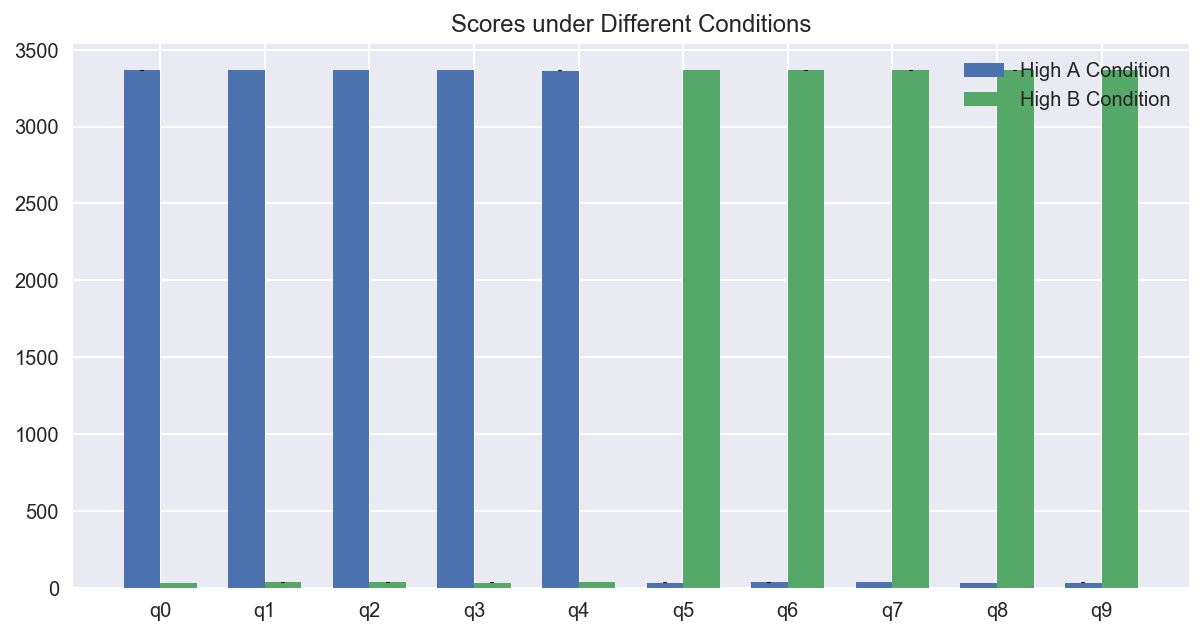

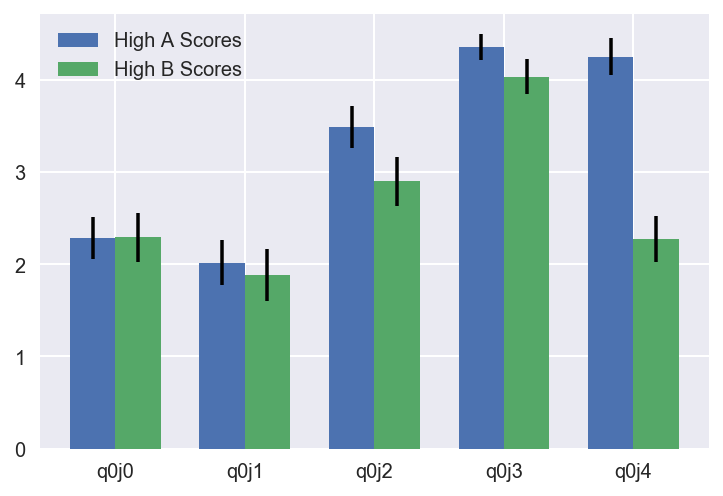

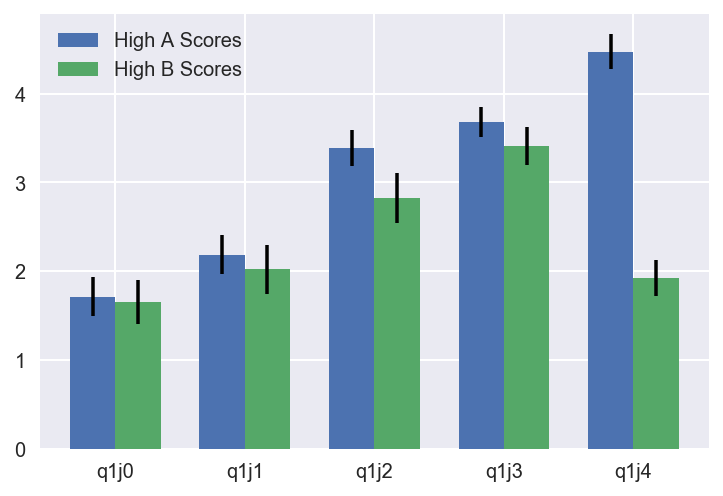

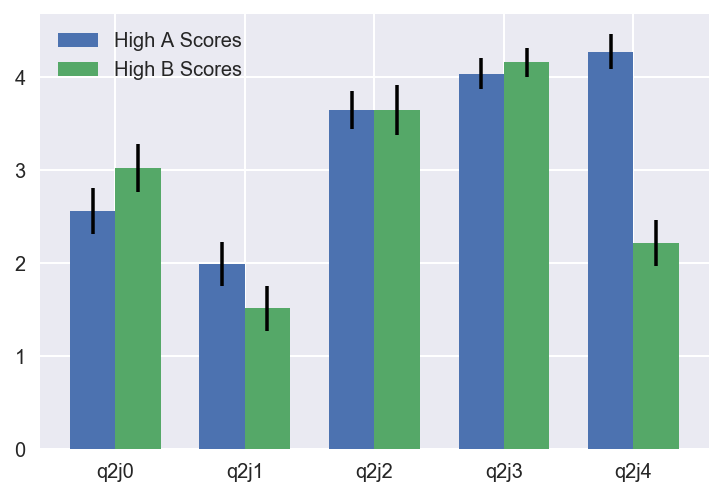

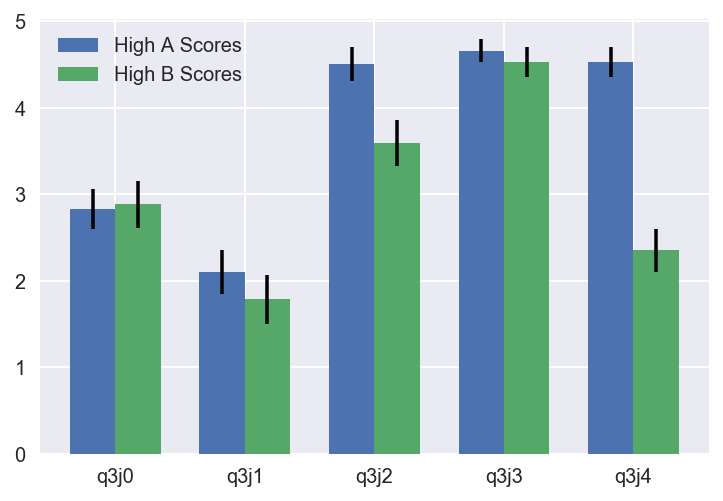

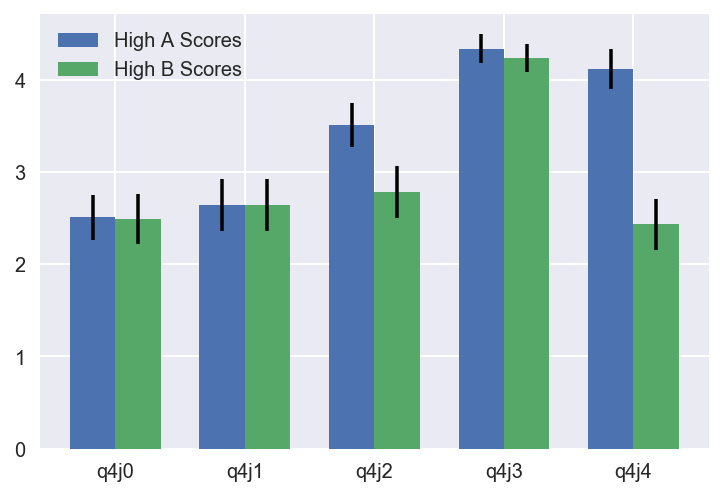

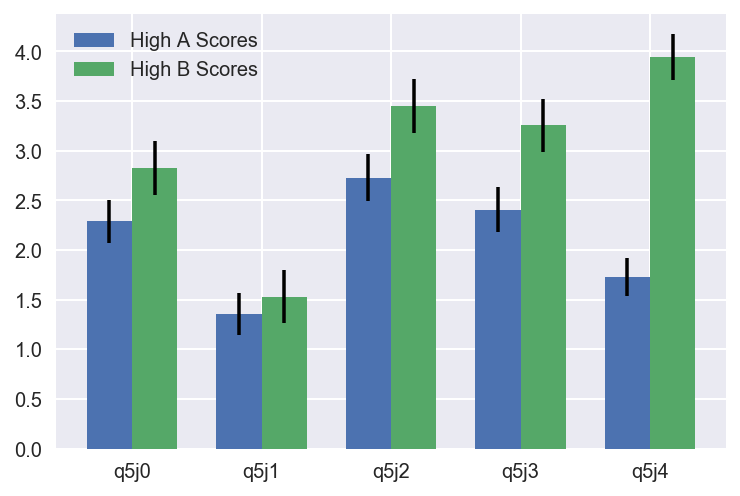

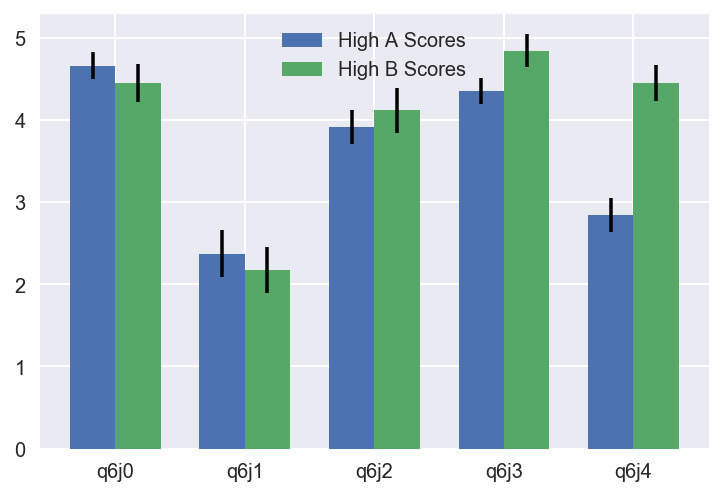

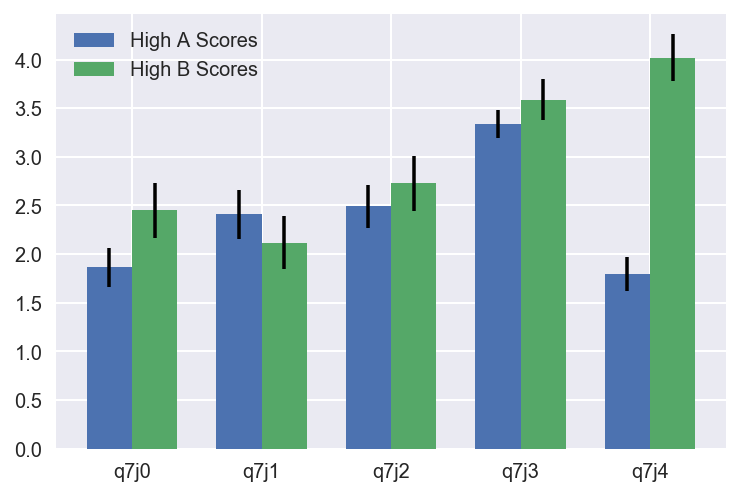

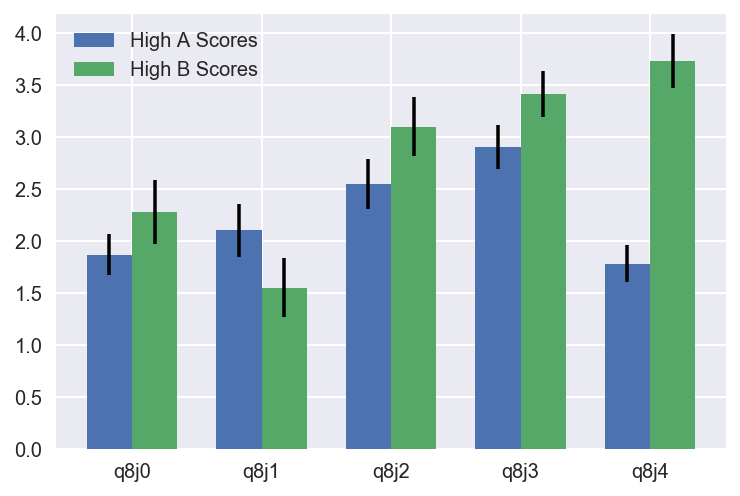

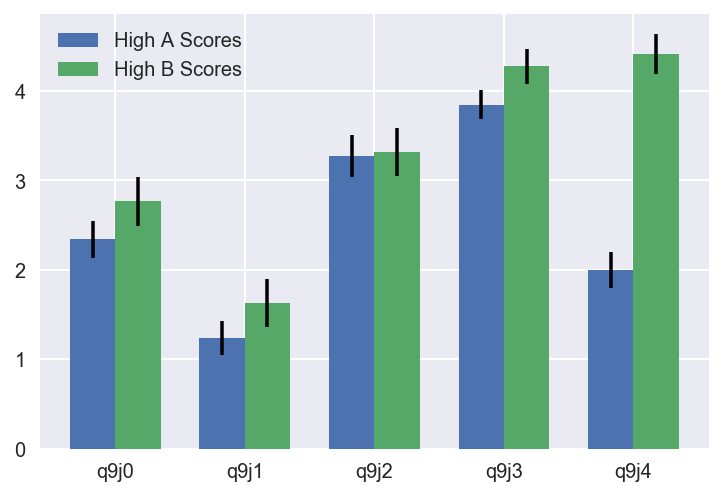

In [45]:
# Score plots
fig, ax = plt.subplots()

labels = [label + 'score' for label in QUESTIONS.values()]
ind, width = np.arange(len(labels)), 0.35

a_means = [high_a[column].mean() for column in labels]
a_stds = [high_a[column].std() / math.sqrt(a_size) for column in labels]
a_rects = ax.bar(ind, a_means, width, yerr=a_stds)

b_means = [high_b[column].mean() for column in labels]
b_stds = [high_b[column].std() / math.sqrt(b_size) for column in labels]
b_rects = ax.bar(ind + width, b_means, width, yerr=b_stds)

ax.set_xticks(ind + width / 2)
ax.set_xticklabels([word[:2] for word in labels])

fig.set_size_inches(10, 5)
plt.title('Scores under Different Conditions')
plt.legend(['High A Condition', 'High B Condition'])
plt.show()

# Compare Question Means
for ques in sorted(QUESTIONS.values()):
    fig, ax = plt.subplots()

    labels = [ques + judge for judge in JUDGEMENTS.values()]
    ind, width = np.arange(len(labels)), 0.35
    
    a_means = [high_a[column].mean() for column in labels]
    a_stds = [high_a[column].std() / math.sqrt(a_size) for column in labels]
    a_rects = ax.bar(ind, a_means, width, yerr=a_stds)
    
    b_means = [high_b[column].mean() for column in labels]
    b_stds = [high_b[column].std() / math.sqrt(b_size) for column in labels]
    b_rects = ax.bar(ind + width, b_means, width, yerr=b_stds)
    
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(labels)
    
    # fig.set_size_inches(10, 5)
    plt.legend(['High A Scores', 'High B Scores'])
    plt.show()

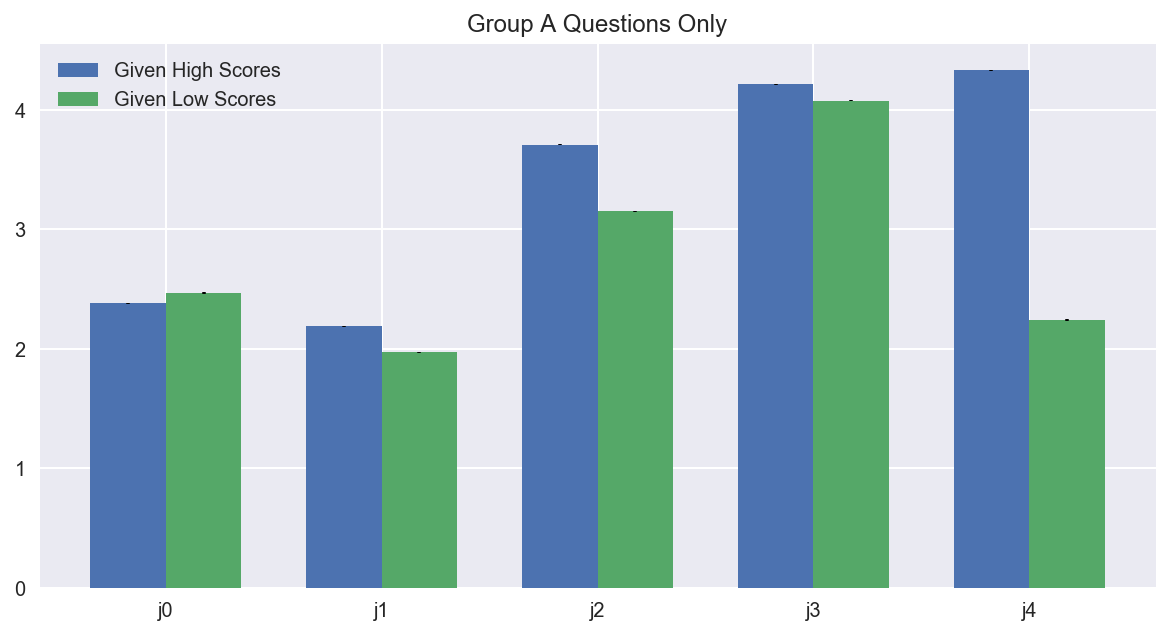

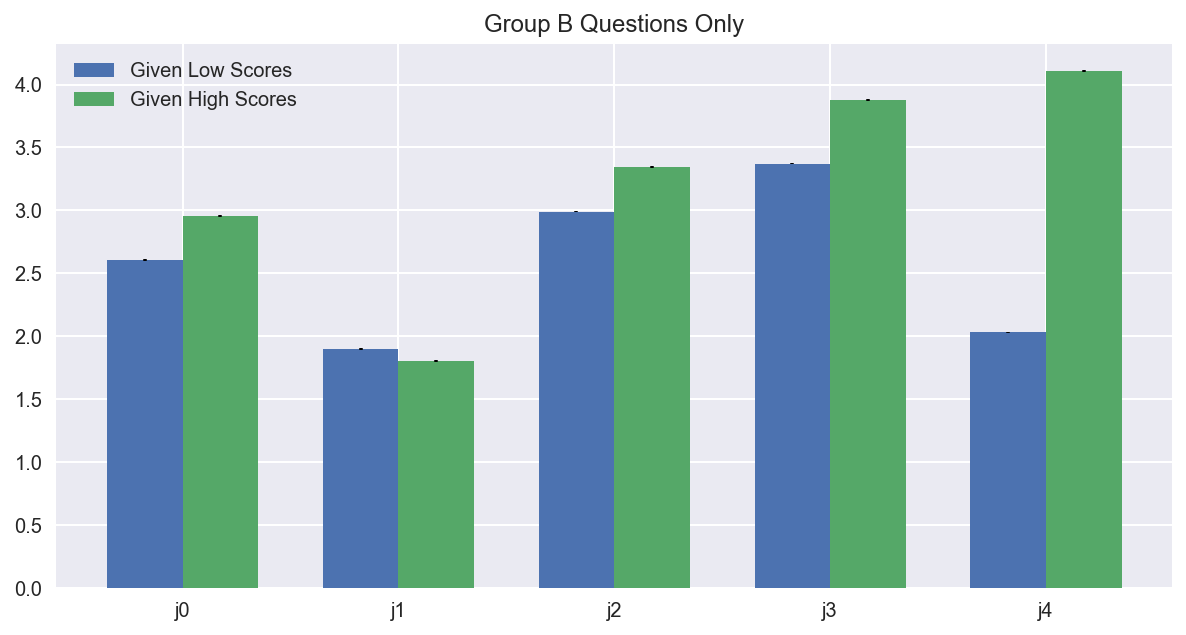

In [41]:
group_a = list(QUESTIONS.values())[:5]
group_b = list(QUESTIONS.values())[5:]
labels = list(JUDGEMENTS.values())

# Comparison of group A questions under both conditions

a_means = []
a_stds = []
group_a_high_a = []
for judge in labels:
    a_series = []
    for ques in group_a:
        a_series.append(high_a[ques + judge])
    a_series = pd.concat(a_series)
    group_a_high_a.append(a_series)
    a_means.append(a_series.mean())
    a_stds.append(a_series.std() / len(a_series))
        
b_means = []
b_stds = []
group_a_high_b = []
for judge in labels:
    b_series = []
    for ques in group_a:
        b_series.append(high_b[ques + judge])
    b_series = pd.concat(b_series)
    group_a_high_b.append(b_series)
    b_means.append(b_series.mean())
    b_stds.append(b_series.std() / len(b_series))
        
fig, ax = plt.subplots()
ind, width = np.arange(len(labels)), 0.35

a_rects = ax.bar(ind, a_means, width, yerr=a_stds)
b_rects = ax.bar(ind + width, b_means, width, yerr=b_stds)

ax.set_xticks(ind + width / 2)
ax.set_xticklabels(labels)

fig.set_size_inches(10, 5)
plt.title('Group A Questions Only')
plt.legend(['Given High Scores', 'Given Low Scores'])
plt.show()

# Comparison of group B questions under both conditions

a_means = []
a_stds = []
group_b_high_a = []
for judge in labels:
    a_series = []
    for ques in group_b:
        a_series.append(high_a[ques + judge])
    a_series = pd.concat(a_series)
    group_b_high_a.append(a_series)
    a_means.append(a_series.mean())
    a_stds.append(a_series.std() / len(a_series))
        
b_means = []
b_stds = []
group_b_high_b = []
for judge in labels:
    b_series = []
    for ques in group_b:
        b_series.append(high_b[ques + judge])
    b_series = pd.concat(b_series)
    group_b_high_b.append(b_series)
    b_means.append(b_series.mean())
    b_stds.append(b_series.std() / len(b_series))
        
fig, ax = plt.subplots()
ind, width = np.arange(len(labels)), 0.35

a_rects = ax.bar(ind, a_means, width, yerr=a_stds)
b_rects = ax.bar(ind + width, b_means, width, yerr=b_stds)

ax.set_xticks(ind + width / 2)
ax.set_xticklabels(labels)

fig.set_size_inches(10, 5)
plt.title('Group B Questions Only')
plt.legend(['Given Low Scores', 'Given High Scores'])
plt.show()

In [42]:
# Runs the statisical tests
print('Group A')
for match, opposite, label in zip(group_a_high_a, group_a_high_b, labels):
    t, prob = scipy.stats.ttest_ind(match, opposite)
    winner = 'high a' if match.mean() > opposite.mean() else 'high b'
    print('{}: t = {}, p = {} ({} greater)'.format(label, t, prob, winner))

print('Group B')
for opposite, match, label in zip(group_b_high_a, group_b_high_b, labels):
    t, prob = scipy.stats.ttest_ind(match, opposite)
    winner = 'high b' if match.mean() > opposite.mean() else 'high a'
    print('{}: t = {}, p = {} ({} greater)'.format(label, t, prob, winner))

Group A
j0: t = -0.5431929157199086, p = 0.5872178574037721 (high b greater)
j1: t = 1.3149537441944494, p = 0.18907543680365121 (high a greater)
j2: t = 3.600841030506509, p = 0.00034599438009014357 (high a greater)
j3: t = 1.2781030437821204, p = 0.20175419375187104 (high a greater)
j4: t = 15.109564372975996, p = 2.2603129113826252e-43 (high a greater)
Group B
j0: t = 2.0803667585230627, p = 0.03795592815010017 (high b greater)
j1: t = -0.5741211846524767, p = 0.5661213698334664 (high a greater)
j2: t = 2.1506950133940554, p = 0.031936929028329744 (high b greater)
j3: t = 3.675898055100563, p = 0.0002603343285181736 (high b greater)
j4: t = 15.237644361222833, p = 5.718701937959031e-44 (high b greater)


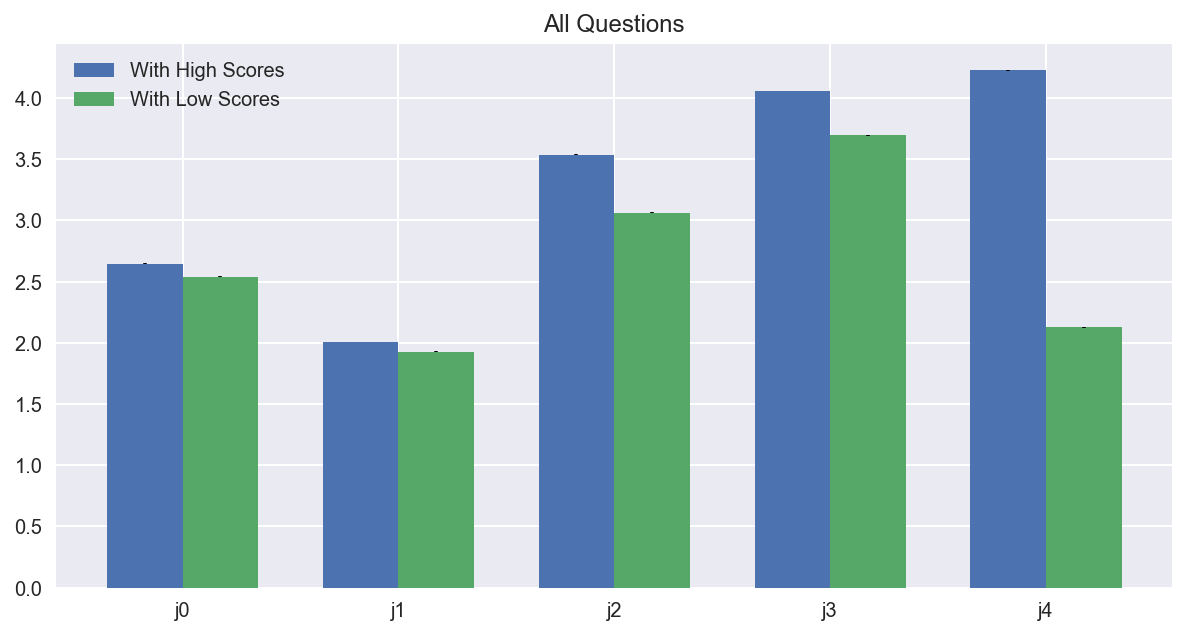

In [43]:
labels = list(JUDGEMENTS.values())

# Compares all matching to all non-matching
match_means = []
match_stds = []
matching_ratings = []
for judge in labels:
    a_series = []
    for ques in group_a:
        a_series.append(high_a[ques + judge])
    for ques in group_b:
        a_series.append(high_b[ques + judge])
    a_series = pd.concat(a_series)
    matching_ratings.append(a_series)
    match_means.append(a_series.mean())
    match_stds.append(a_series.std() / len(a_series))
    
opposite_means = []
opposite_stds = []
opposite_ratings = []
for judge in labels:
    b_series = []
    for ques in group_a:
        b_series.append(high_b[ques + judge])
    for ques in group_b:
        b_series.append(high_a[ques + judge])
    b_series = pd.concat(b_series)
    opposite_ratings.append(b_series)
    opposite_means.append(b_series.mean())
    opposite_stds.append(b_series.std() / len(b_series))
    

fig, ax = plt.subplots()
ind, width = np.arange(len(labels)), 0.35

a_rects = ax.bar(ind, match_means, width, yerr=match_stds)
b_rects = ax.bar(ind + width, opposite_means, width, yerr=opposite_stds)

ax.set_xticks(ind + width / 2)
ax.set_xticklabels(labels)

fig.set_size_inches(10, 5)
plt.title('All Questions')
plt.legend(['With High Scores', 'With Low Scores'])
plt.show()

In [13]:
# Runs the statisical tests
for match, opposite, label in zip(matching_ratings, opposite_ratings, labels):
    t, prob = scipy.stats.ttest_ind(match, opposite)
    winner = 'higher' if match.mean() > opposite.mean() else 'lower'
    print('{}: t = {}, p = {} ({} greater)'.format(label, t, prob, winner))

j0: t = 2.0181105729498885, p = 0.04384690829071165 (higher greater)
j1: t = 0.292520690256839, p = 0.7699493456887071 (higher greater)
j2: t = 2.630218162051123, p = 0.008664392505527049 (higher greater)
j3: t = 2.0721931338232937, p = 0.03850377690418222 (higher greater)
j4: t = 16.119999961375292, p = 3.923267576093897e-52 (higher greater)


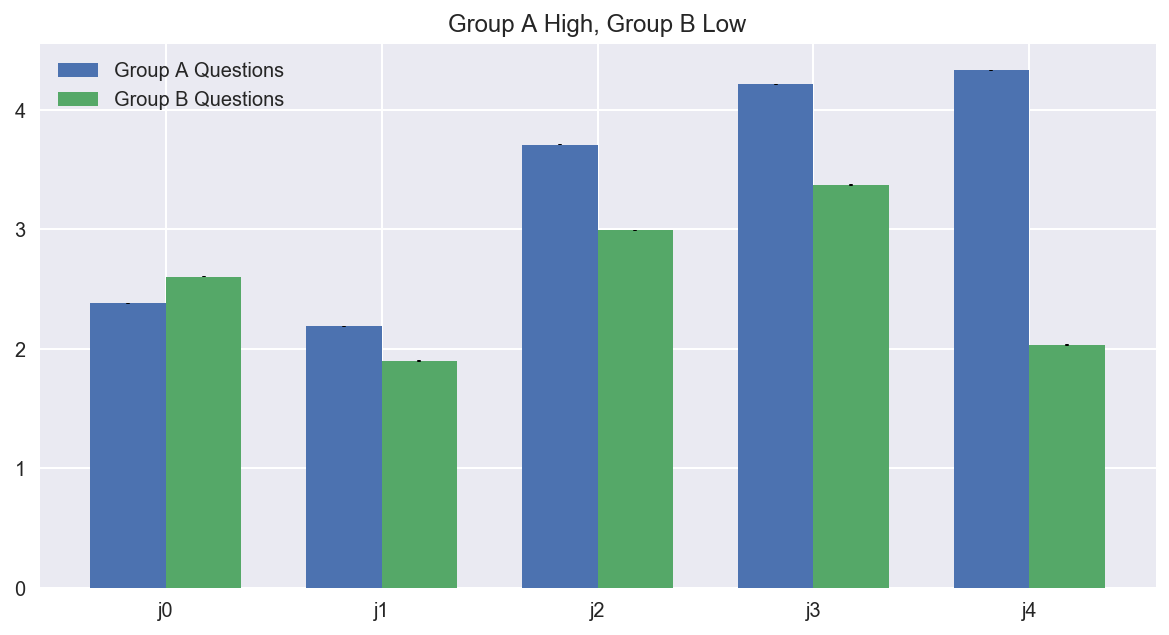

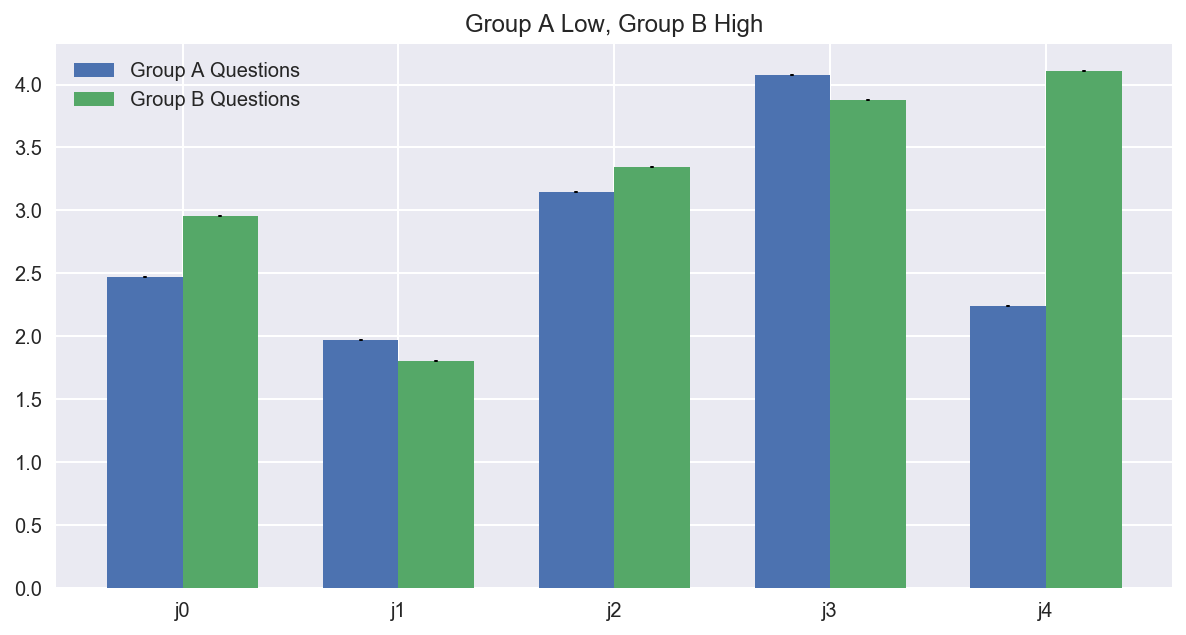

In [44]:
labels = list(JUDGEMENTS.values())

# Condition A comparison
a_means = []
a_stds = []
for judge in labels:
    a_series = []
    for ques in group_a:
        a_series.append(high_a[ques + judge])
    a_series = pd.concat(a_series)
    a_means.append(a_series.mean())
    a_stds.append(a_series.std() / len(a_series))
        
b_means = []
b_stds = []
for judge in labels:
    b_series = []
    for ques in group_b:
        b_series.append(high_a[ques + judge])
    b_series = pd.concat(b_series)
    b_means.append(b_series.mean())
    b_stds.append(b_series.std() / len(b_series))
        
fig, ax = plt.subplots()
ind, width = np.arange(len(labels)), 0.35

a_rects = ax.bar(ind, a_means, width, yerr=a_stds)
b_rects = ax.bar(ind + width, b_means, width, yerr=b_stds)

ax.set_xticks(ind + width / 2)
ax.set_xticklabels(labels)

fig.set_size_inches(10, 5)
plt.title('Group A High, Group B Low')
plt.legend(['Group A Questions', 'Group B Questions'])
plt.show()

# Condition B comparison

a_means = []
a_stds = []
for judge in labels:
    a_series = []
    for ques in group_a:
        a_series.append(high_b[ques + judge])
    a_series = pd.concat(a_series)
    a_means.append(a_series.mean())
    a_stds.append(a_series.std() / len(a_series))
        
b_means = []
b_stds = []
for judge in labels:
    b_series = []
    for ques in group_b:
        b_series.append(high_b[ques + judge])
    b_series = pd.concat(b_series)
    b_means.append(b_series.mean())
    b_stds.append(b_series.std() / len(b_series))
        
fig, ax = plt.subplots()
ind, width = np.arange(len(labels)), 0.35

a_rects = ax.bar(ind, a_means, width, yerr=a_stds)
b_rects = ax.bar(ind + width, b_means, width, yerr=b_stds)

ax.set_xticks(ind + width / 2)
ax.set_xticklabels(labels)

fig.set_size_inches(10, 5)
plt.title('Group A Low, Group B High')
plt.legend(['Group A Questions', 'Group B Questions'])
plt.show()

## Answers Analysis
For this study we also look at whether or not being highly upvoted correspondeds to be chosen more frequently to see the answers for.

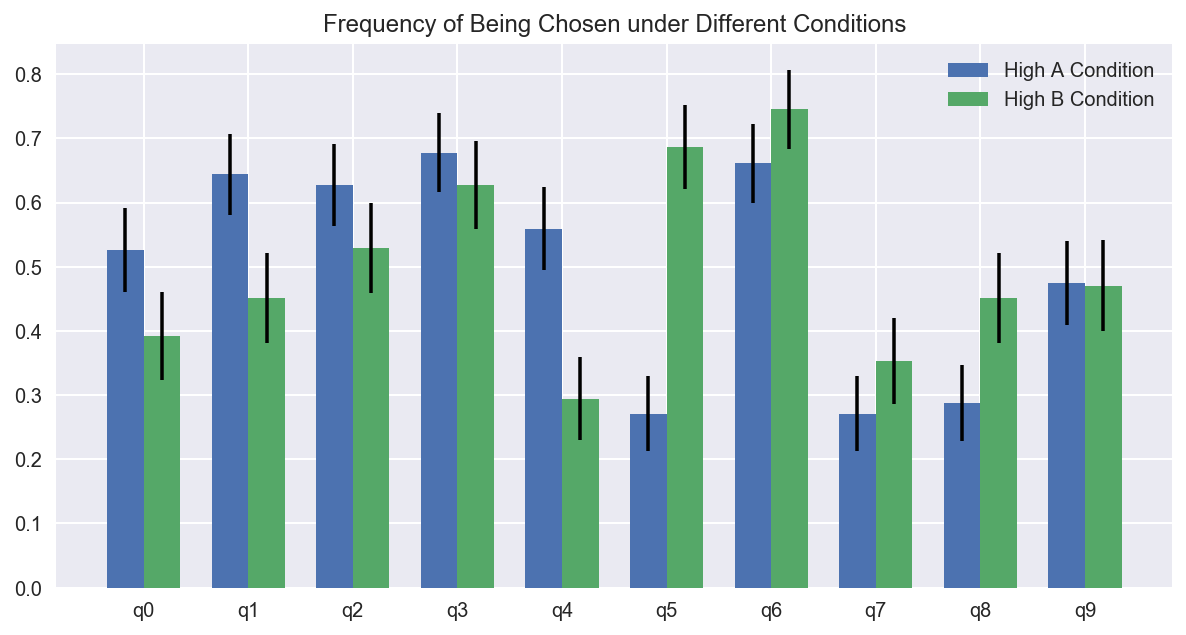

In [47]:
fig, ax = plt.subplots()

labels = [label + 'choice' for label in QUESTIONS.values()]
ind, width = np.arange(len(labels)), 0.35

a_means = [high_a[column].mean() for column in labels]
a_stds = [high_a[column].std() / math.sqrt(a_size) for column in labels]
a_rects = ax.bar(ind, a_means, width, yerr=a_stds)

b_means = [high_b[column].mean() for column in labels]
b_stds = [high_b[column].std() / math.sqrt(b_size) for column in labels]
b_rects = ax.bar(ind + width, b_means, width, yerr=b_stds)

ax.set_xticks(ind + width / 2)
ax.set_xticklabels([word[:2] for word in labels])

fig.set_size_inches(10, 5)
plt.title('Frequency of Being Chosen under Different Conditions')
plt.legend(['High A Condition', 'High B Condition'])
plt.show()